In [2]:
import json
import time

import numpy as np
import seaborn as sn

from classify import classify

np.random.seed(0)

questions = open('tossups.json').readlines() + open('bonuses.json').readlines()
np.random.shuffle(questions)
questions = questions[:int(0.2*len(questions))]
print('Number of questions in test set:', len(questions))

with open('subcategories.txt') as f:
    SUBCATEGORIES = [line.strip() for line in f.readlines()]

Number of questions in test set: 62618


In [3]:
EPSILON = 0.01

print('=====Begin Testing=====')
time_now = time.perf_counter()

counter = 0
correct = 0
confusion_matrix = [[0 for _ in range(len(SUBCATEGORIES))] for _ in range(len(SUBCATEGORIES))]

for line in questions:
    data = json.loads(line)
    data["type"] = "tossup" if "question" in data else "bonus"

    if 'subcategory' not in data:
        continue

    subcategory = data['subcategory']

    if subcategory not in SUBCATEGORIES:
        continue

    counter += 1

    if data['type'] == 'tossup':
        prediction = classify(data['question_sanitized'] + ' ' + data['answer_sanitized'], EPSILON=EPSILON)

    if data['type'] == 'bonus' and 'parts_sanitized' in data and len(data['parts_sanitized']) == 3:
        prediction = classify(data['leadin_sanitized'] + ' ' + ' '.join(data['parts_sanitized']) + ' ' + ' '.join(data['answers_sanitized']), EPSILON=EPSILON)

    subcategory_index = SUBCATEGORIES.index(subcategory)
    prediction_index = SUBCATEGORIES.index(prediction)

    confusion_matrix[subcategory_index][prediction_index] += 1

    if subcategory == prediction:
        correct += 1

    if counter % 10000 == 0:
        print(f'{correct}/{counter}')

print('=====End Testing=====')
print(f'Accuracy: {100 * correct / counter}% ({correct}/{counter})')
print(f'Time: {time.perf_counter() - time_now} seconds')

=====Begin Testing=====
8637/10000
17219/20000
25869/30000
34456/40000
43041/50000
51663/60000
=====End Testing=====
Accuracy: 86.10578105781057% (52503/60975)
Time: 11.260282000002917 seconds


In [4]:
for i, subcat in enumerate(SUBCATEGORIES):
    accuracy = 0.0 if sum(confusion_matrix[i]) == 0 else confusion_matrix[i][i] / sum(confusion_matrix[i])
    accuracy = round(100 * accuracy, 2)
    print(f'{subcat + ":":21} {str(confusion_matrix[i][i]) + "/" + str(sum(confusion_matrix[i])):10} ({accuracy}%)')

American Literature:  3321/3965  (83.76%)
British Literature:   2914/3348  (87.04%)
European Literature:  2389/2690  (88.81%)
World Literature:     1745/2064  (84.54%)
American History:     3349/3938  (85.04%)
Ancient History:      776/905    (85.75%)
European History:     3869/4755  (81.37%)
World History:        2931/3661  (80.06%)
Biology:              2849/3127  (91.11%)
Chemistry:            2302/2600  (88.54%)
Physics:              2911/3221  (90.38%)
Other Science:        2635/3041  (86.65%)
Visual Fine Arts:     3259/3614  (90.18%)
Auditory Fine Arts:   2879/3348  (85.99%)
Other Fine Arts:      1374/1877  (73.2%)
Religion:             2167/2413  (89.81%)
Mythology:            2609/2862  (91.16%)
Philosophy:           2190/2369  (92.44%)
Social Science:       2035/2308  (88.17%)
Current Events:       548/741    (73.95%)
Geography:            1533/1853  (82.73%)
Trash:                1918/2275  (84.31%)


In [5]:
print('Confusion Matrix:')
for subcat, row in zip(SUBCATEGORIES, confusion_matrix):
    print(f'{subcat:20}', row)

Confusion Matrix:
American Literature  [3321, 122, 119, 153, 26, 3, 13, 4, 3, 0, 2, 4, 8, 6, 28, 11, 7, 18, 16, 3, 6, 92]
British Literature   [137, 2914, 91, 57, 9, 5, 21, 3, 0, 2, 1, 5, 7, 4, 14, 3, 20, 18, 6, 3, 3, 25]
European Literature  [63, 83, 2389, 50, 2, 2, 10, 4, 2, 0, 1, 2, 3, 7, 17, 2, 19, 15, 6, 0, 5, 8]
World Literature     [83, 67, 87, 1745, 3, 1, 3, 2, 1, 2, 0, 1, 4, 1, 11, 4, 23, 4, 6, 5, 4, 7]
American History     [34, 8, 3, 3, 3349, 8, 63, 86, 3, 4, 2, 13, 9, 2, 22, 16, 3, 13, 30, 134, 72, 61]
Ancient History      [2, 3, 1, 0, 5, 776, 38, 29, 1, 1, 0, 4, 7, 0, 0, 13, 4, 5, 7, 2, 6, 1]
European History     [23, 18, 18, 6, 111, 189, 3869, 167, 4, 3, 4, 1, 25, 3, 31, 40, 6, 42, 22, 85, 70, 18]
World History        [7, 6, 3, 12, 69, 135, 152, 2931, 1, 2, 2, 2, 7, 2, 18, 30, 13, 9, 9, 112, 129, 10]
Biology              [5, 2, 4, 2, 17, 2, 5, 4, 2849, 73, 19, 28, 6, 2, 6, 3, 2, 8, 61, 3, 18, 8]
Chemistry            [4, 2, 2, 0, 4, 0, 11, 4, 48, 2302, 183, 17, 1, 2, 1, 1, 

<Axes: >

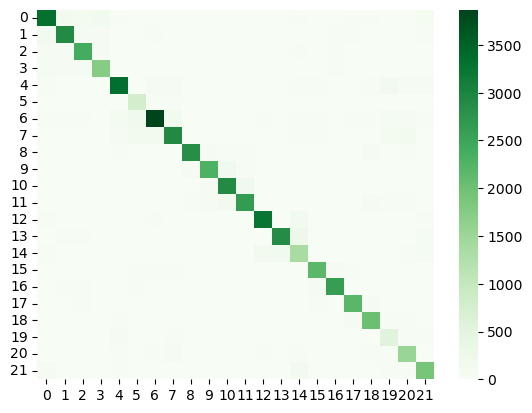

In [6]:
sn.heatmap(confusion_matrix, cmap='Greens', annot=False)

<Axes: >

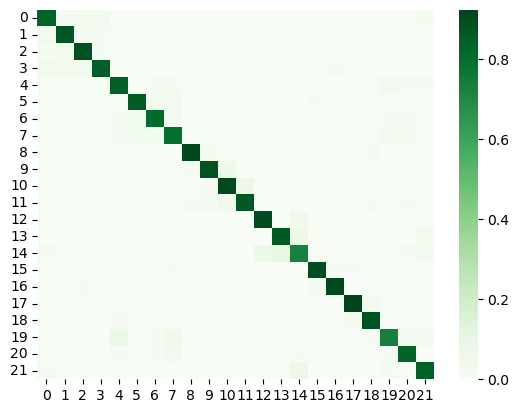

In [7]:
# use relative proportions instead of absolute values
sn.heatmap([[confusion_matrix[i][j] / sum(confusion_matrix[i]) for j in range(len(confusion_matrix[i]))] for i in range(len(confusion_matrix))], cmap='Greens', annot=False)